In [5]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [31]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'

test_directory = './data/lunar/test/data/S12_GradeB/'

TRAINING_RELATION = 0.8

cat = pd.read_csv(cat_file)
cat.shape[0]

76

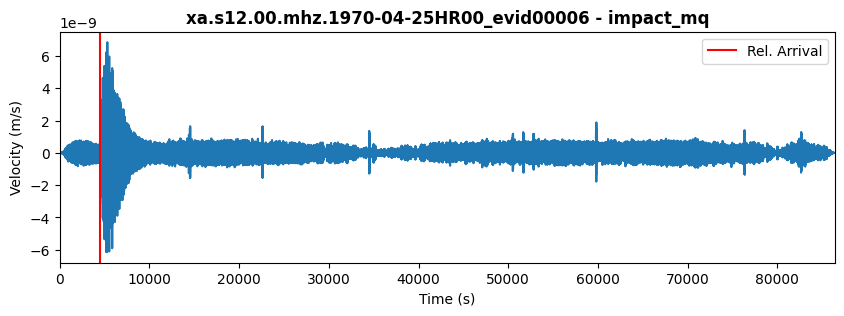

In [32]:
row = cat.iloc[3]
test_filename = row.filename

mq_type = row['mq_type']
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']

csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(csv_times, csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times), max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename} - {mq_type}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

In [42]:
def get_power(data):
    return np.sum(np.abs(data)**2)

def get_bandwidth(data, times):
    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)
    return np.sum(np.abs(fft)**2)

def get_spectral_entropy(data):
    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)
    return -np.sum(power * np.log(power))

def get_peak_frequency(data, times):
    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)
    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_dominant_frequency(data, times):
    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)
    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_centroid_frequency(data, times):
    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)
    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_mean_frequency(data, times):
    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)
    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_spectral_amplitude(data):
    fft = np.fft.fft(data)
    return np.max(np.abs(fft))

def get_characteristics(data, times):
    power = get_power(data)
    bandwidth = get_bandwidth(data, times)
    spectral_entropy = get_spectral_entropy(data)
    peak_frequency = get_peak_frequency(data, times)
    dominant_frequency = get_dominant_frequency(data, times)
    centroid_frequency = get_centroid_frequency(data, times)
    mean_frequency = get_mean_frequency(data, times)
    spectral_amplitude = get_spectral_amplitude(data)

    return dict(
        power=power,
        bandwidth=bandwidth,
        spectral_entropy=spectral_entropy,
        peak_frequency=peak_frequency,
        dominant_frequency=dominant_frequency,
        centroid_frequency=centroid_frequency,
        mean_frequency=mean_frequency,
        spectral_amplitude=spectral_amplitude
    )

def get_mq_type(mq_type):
    if mq_type == 'impact_mq':
        return 0 # Impact
    elif mq_type == 'deep_mq':
        return 1 # Deep moonquake
    else:
        return 2 # Shallow moonquake

def get_training_characteristics():
    characteristics = []
    limit = int(cat.shape[0] * TRAINING_RELATION)

    for i in range(1, limit):
        row = cat.iloc[i]
        filename = row.filename
        mq_type = row.mq_type

        csv_file = f'{data_directory}{filename}.csv'
        data_cat = pd.read_csv(csv_file)

        csv_times = np.array(data_cat['time_rel(sec)'].tolist())
        csv_data = np.array(data_cat['velocity(m/s)'].tolist())

        characteristics.append(dict(
            mq_type=get_mq_type(mq_type),
            **get_characteristics(csv_data, csv_times)
        ))
        print(f'Processed training file{i}/{limit} ({filename})')

    return pd.DataFrame(characteristics)

def get_test_characteristics():
    characteristics = []
    bottom_limit = int(cat.shape[0] * TRAINING_RELATION)
    top_limit = int(cat.shape[0] * (1 - TRAINING_RELATION))

    for i in range(bottom_limit, top_limit):
        row = cat.iloc[i]
        filename = row.filename
        mq_type = row.mq_type

        csv_file = f'{test_directory}{filename}.csv'
        data_cat = pd.read_csv(csv_file)

        csv_times = np.array(data_cat['time_rel(sec)'].tolist())
        csv_data = np.array(data_cat['velocity(m/s)'].tolist())

        characteristics.append(dict(
            mq_type=get_mq_type(mq_type),
            **get_characteristics(csv_data, csv_times)
        ))
        print(f'Processed test file {bottom_limit + i}/{top_limit} ({filename})')

    return pd.DataFrame(characteristics)

In [ ]:
training_characteristics = get_training_characteristics()
test_characteristics = get_test_characteristics()

Processed training file1/60 (xa.s12.00.mhz.1970-03-25HR00_evid00003)
Processed training file2/60 (xa.s12.00.mhz.1970-03-26HR00_evid00004)


In [35]:
# import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [36]:
model = Sequential([
    Input(shape=(8,)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
history = model.fit(
    training_characteristics[['power', 'bandwidth', 'spectral_entropy', 'peak_frequency', 'dominant_frequency', 'centroid_frequency', 'mean_frequency', 'spectral_amplitude']],
    training_characteristics[['mq_type']],
    epochs=100,
    batch_size=4
)

Epoch 1/100


c:\Users\maria\OneDrive\Escritorio\_\NSAC\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\.venv\lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1958 - loss: 0.0000e+00 
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4590 - loss: 0.0000e+00   
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.7434 - loss: 0.0000e+00
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8027 - loss: 0.0000e+00
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.0000e+00 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8576 - loss: 0.0000e+00
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.0000e+00
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8423 - loss: 0.0000e+00
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.8603 - loss: 0.0000e+00
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8302 - loss: 0.0000e+00
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8435 - loss: 0.0000e+00
Epoch 12/100
15/15

In [39]:
test_characteristics

""
